In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Practical 3: Kalman Filter

## Introduction

In this practical, we will be implementing a simple Kalman Filter.
We are following the notation used in *Bayesian Filtering and Smoothing* by Simo Särkkä; the Kalman Filter is detailed in chapter 4.3.

First, we create some synthetic data to demonstrate how we can recover the underlying states from observations if we know the generating model.

Next, we apply the filter to some real data: we will be looking at filtering Sentinel-3 Land Surface Temperature (LST) data.

---

# Part 1: Synthetic Data

## 1. Set up model parameters

Throughout this exercise, we will assume that all of $\mathbf{H}_k$, $\mathbf{A}_k$, $\mathbf{Q}_k$ and $\mathbf{R}_k$ are constant (do not depend on $k$).

In [3]:
# Input dimension
N = 4

# Fix the seed for the random number generator
# so we get the same "random" numbers each time
np.random.seed(0)

# A_k: Dynamic model matric (i.e. transition matrix)

# Set up a simple model
A = np.eye(N)
H = np.random.rand(4, 4)
Q = np.eye(N)
R = np.eye(N)

## 2. Simulate data ($x_k$)

$$\mathbf{x}_k = \mathbf{A}_{k-1}\mathbf{x}_{k-1} + \mathbf{q}_{k-1}$$

$$\mathbf{q}_{k-1} \sim N(\mathbf{0}, \mathbf{Q}_{k-1})$$

In [4]:
# Number of time steps
Nk = 100

# Generate x_k states
x = np.zeros((N, Nk))
for k in range(1, Nk):
    q = np.random.multivariate_normal(np.zeros(N), Q) #process noise
    x[:, k] = A.dot(x[:, k-1]) + q                    # state at time k

## 3. Simulate observations ($y_k$)

cf. Särkkä eq. (4.17)

$$\mathbf{y}_k = \mathbf{H}_{k}\mathbf{x}_{k} + \mathbf{r}_{k}$$

$$\mathbf{r}_{k} \sim N(\mathbf{0}, \mathbf{R}_{k})$$

In [5]:
# Generate y_k (measurements)
r = np.random.multivariate_normal(np.zeros(N), R, size=Nk) # measurement noise
y = H.dot(x) + r.T                                         # measurements

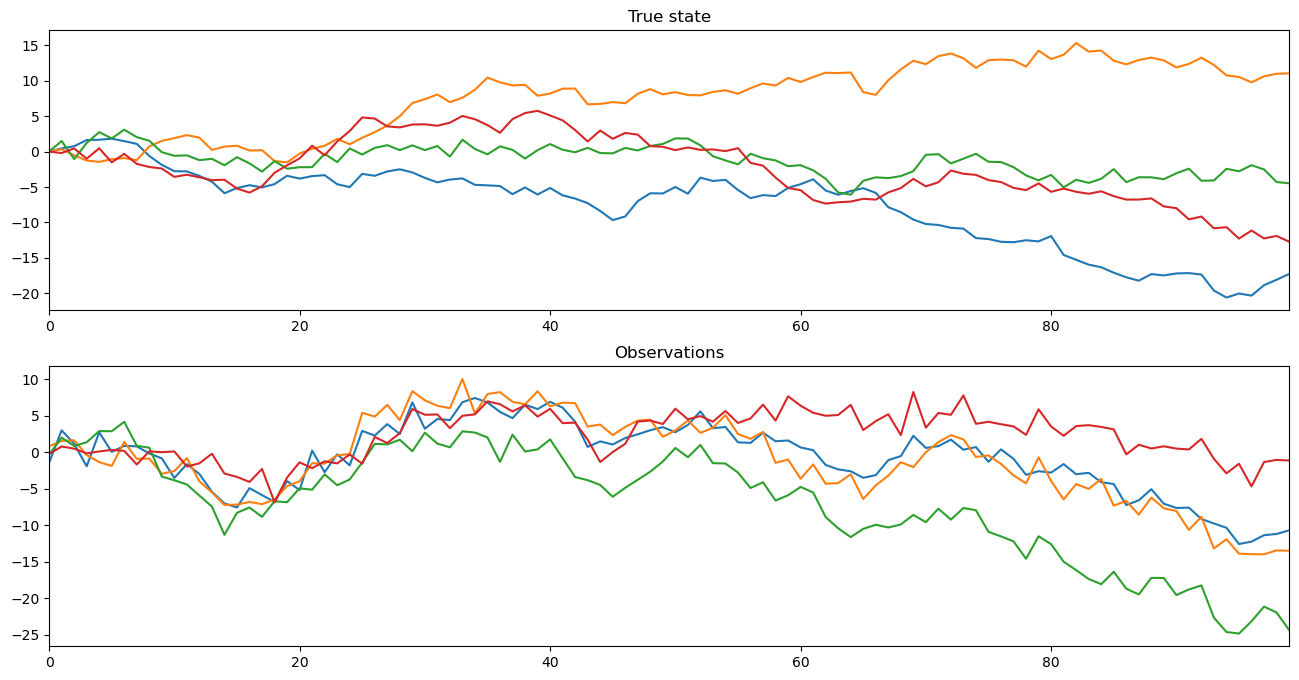

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].plot(x.T)
ax[0].set_title('True state')
ax[1].plot(y.T)
ax[1].set_title('Observations');
for a in ax:
    a.autoscale(enable=True, axis='x', tight=True)

## 4. Apply Kalman filter

1. Prediction step (cf. Särkkä eq. (4.20)):

    $\mathbf{m}^{-}_k = \mathbf{A}_{k-1}\mathbf{m}_{k-1}$
    
    $\mathbf{P}^{-}_k = \mathbf{A}_{k-1}\mathbf{P}_{k-1}\mathbf{A}^T_{k-1} + \mathbf{Q}_{k-1}$


2. Update step (cf. Särkkä eq. (4.21)):

    $\mathbf{v}_k = \mathbf{y}_k - \mathbf{H}_k \mathbf{m}^{-}_k$
    
    $\mathbf{S}_k = \mathbf{H}_k \mathbf{P}^{-}_k \mathbf{H}^T_k + \mathbf{R}_k$
    
    $\mathbf{K}_k = \mathbf{P}^{-}_k \mathbf{H}^T_k \mathbf{S}^{-1}_k$
    
    $\mathbf{m}_k = \mathbf{m}^{-}_k + \mathbf{K}_k \mathbf{v}_k$
    
    $\mathbf{P}_k = \mathbf{P}^{-}_k - \mathbf{K}_k \mathbf{S}_k \mathbf{K}^T_k$

In [8]:
# predicted mean at time step k
# predicted covariance at time step k
# gain matrix of a kalman filter
# innovation vector at time step k
# innovation covariance at time step k

# Initialise m and P
m = np.zeros((N, Nk))
P = np.zeros((N, N, Nk))

# Set prior mean and covariance explicitly:
m[:, 0] = np.zeros(N)
P[:, :, 0] = np.eye(N)

# Initialise the predictive mean and covariance
mp = m.copy()
Pp = P.copy()

In [9]:
##### These are the seven most important lines #######

for k in range(1, Nk):
    # 1. Prediction step
    mp[:, k] = A.dot(m[:, k-1])
    Pp[:, :, k] = A.dot(P[:, :, k-1]).dot(A.T) + Q
    
    # 2. Update step
    v = y[:, k] - H.dot(mp[:, k])
    S = H.dot(Pp[:, :, k]).dot(H.T) + R
    K = Pp[:, :, k].dot(H.T).dot(np.linalg.inv(S))
    m[:, k] = mp[:, k] + K.dot(v)
    P[:, :, k] = Pp[:, :, k] - K.dot(S).dot(K.T)

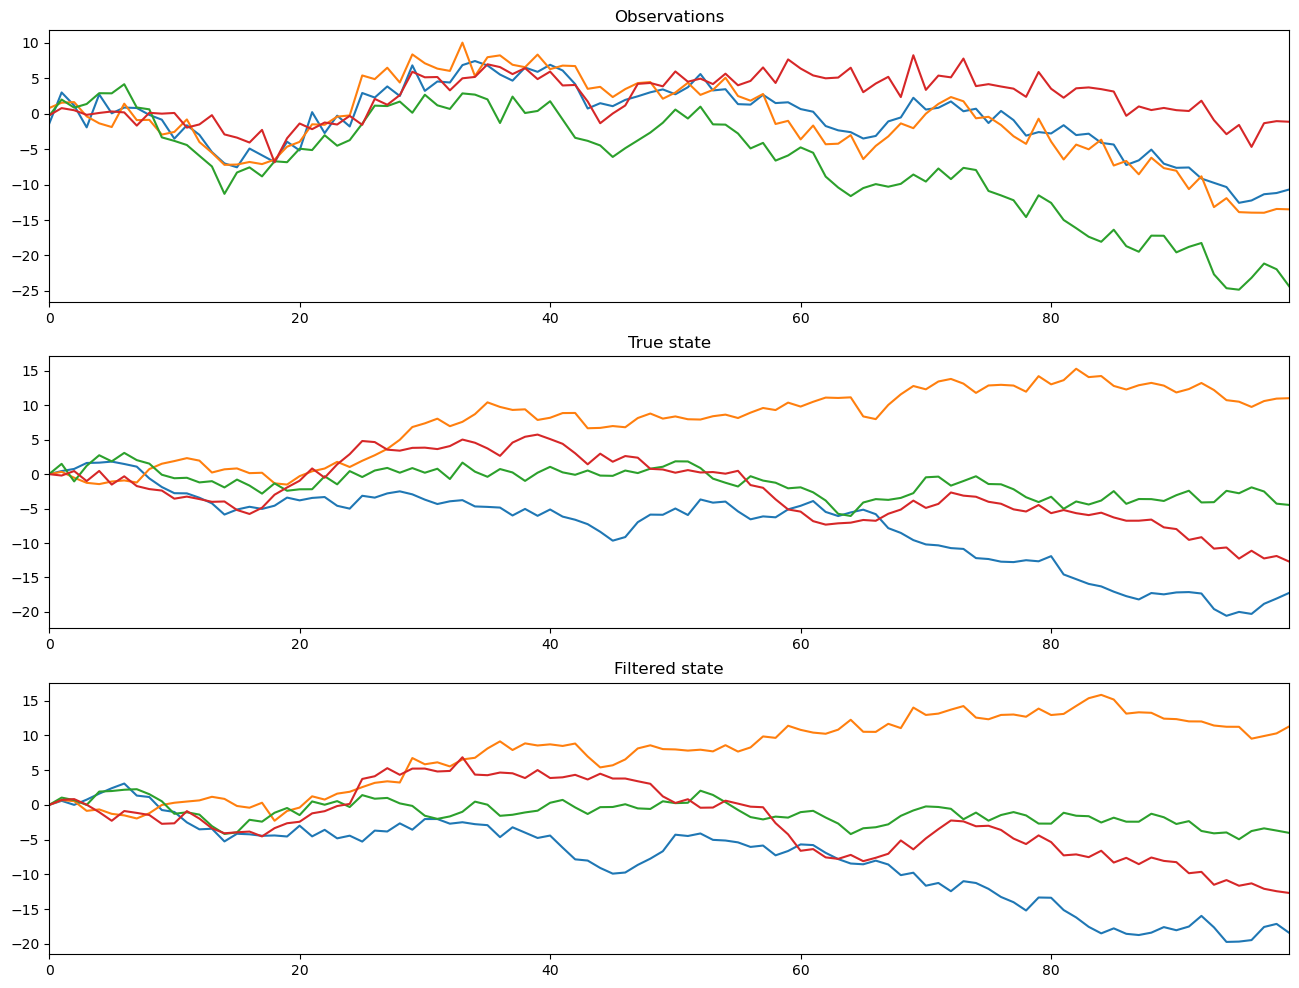

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(16, 12))
ax[0].plot(y.T)
ax[0].set_title('Observations')
ax[1].plot(x.T)
ax[1].set_title('True state')
ax[2].plot(m.T)
ax[2].set_title('Filtered state');
for a in ax:
    a.autoscale(enable=True, axis='x', tight=True)

As you can see, we recover the true state fairly well. This is of course reliant on knowing the generating model parameters.

## Exercise 1: Implement the Kalman smoother

cf. Särkkä eq. (8.6)

Kalman filter prediction:

$$\mathbf{m}^-_{k+1} = \mathbf{A}_k \mathbf{m}_k$$

$$\mathbf{P}^-_{k+1} = \mathbf{A}_k \mathbf{P}_k \mathbf{A}^T_k + \mathbf{Q}_k$$

Kalman smoother:

$$\mathbf{G}_k = \mathbf{P}_k \mathbf{A}_k^T \left[ \mathbf{P}^-_{k+1} \right]^{-1}$$

$$\mathbf{m}^s_k = \mathbf{m}_k + \mathbf{G}_k \left[ \mathbf{m}^s_{k+1} - \mathbf{m}^-_{k+1} \right]$$

$$\mathbf{P}^s_k = \mathbf{P}_k + \mathbf{G}_k \left[ \mathbf{P}^s_{k+1} - \mathbf{P}^-_{k+1} \right] \mathbf{G}^T_k$$

The backward recursion is started from the last time step $T$ with $\mathbf{m}^s_T = \mathbf{m}_T$ and $\mathbf{P}^s_T = \mathbf{P}_T$.

You may reuse the predictive mean and covariance computed previously.

### Kalman Filter only uses previous observations. It is non-cheating.


##

In [11]:
ms = m.copy()
Ps = P.copy()

# Add your code here:
#  ...

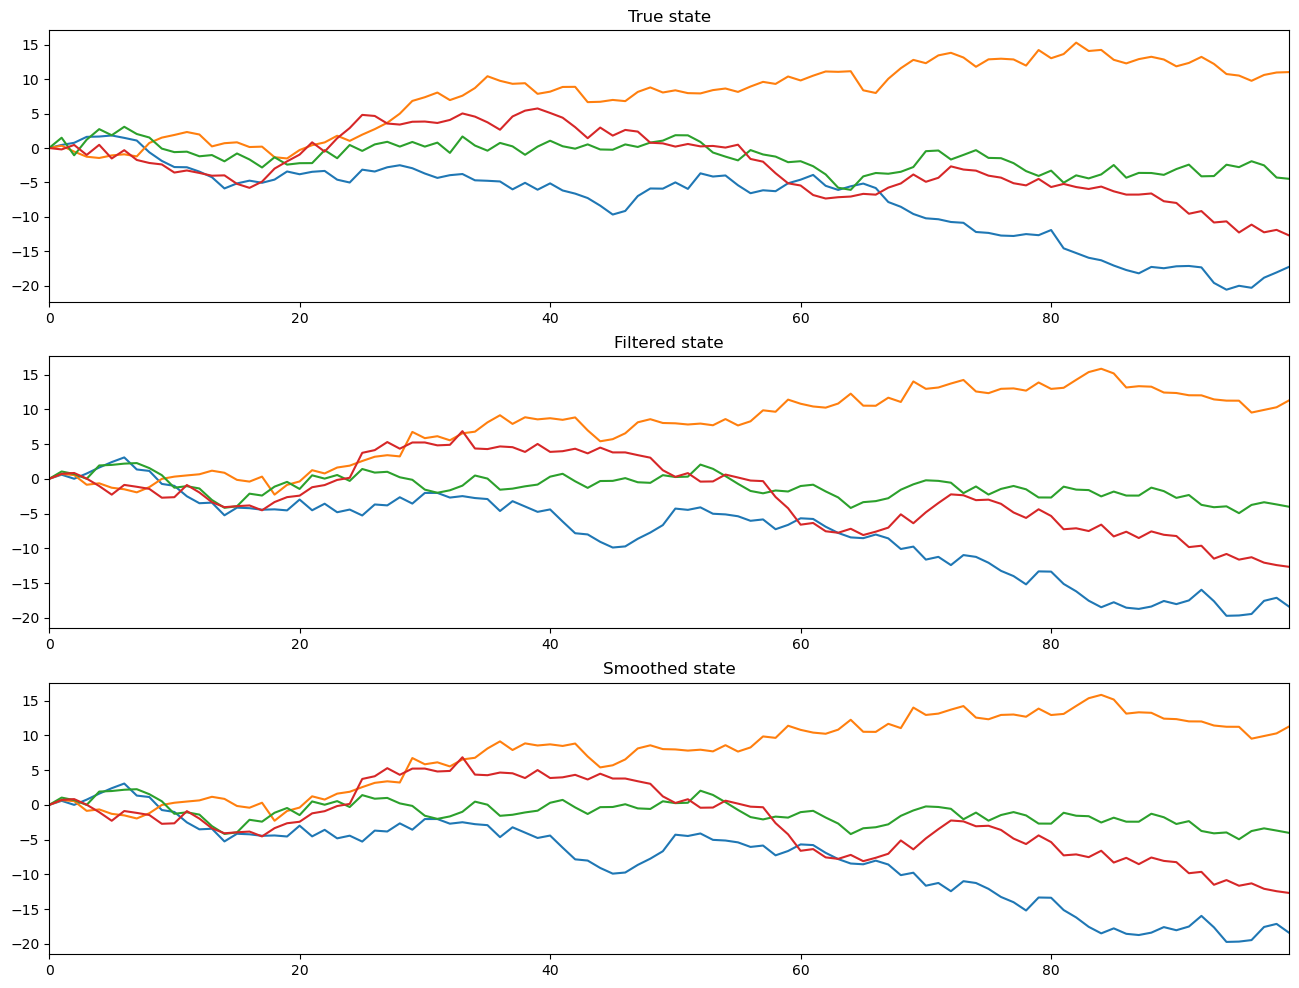

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(16, 12))
ax[0].plot(x.T)
ax[0].set_title('True state')
ax[1].plot(m.T)
ax[1].set_title('Filtered state')
ax[2].plot(ms.T)
ax[2].set_title('Smoothed state');
for a in ax:
    a.autoscale(enable=True, axis='x', tight=True)

---

# Part 2: Real Data

In the `data` directory you will find a time series of Sentinel-3 Land Surface Temperature (LST) measurements over Egypt for the year 2019.

In [13]:
lst = xr.open_dataset('data/s3_lst_egypt.nc')

C:\Users\s2112771\Anaconda3\envs\SENSE_training\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing crs: The specified module could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [14]:
lst

<xarray.Dataset>
Dimensions:          (time: 50, y: 700, x: 700)
Coordinates:
    band             int64 ...
    lat              (y, x) float64 ...
    lon              (y, x) float64 ...
  * time             (time) datetime64[ns] 2019-01-03T19:56:22 ... 2019-12-30...
  * x                (x) float64 7.131e+05 7.141e+05 ... 1.39e+06 1.391e+06
  * y                (y) float64 1.396e+06 1.395e+06 ... 7.195e+05 7.185e+05
Data variables:
    LST              (time, y, x) float32 ...
    LST_uncertainty  (time, y, x) float32 ...
Attributes: (12/23)
    GeoTransform:              [ 1.61035890e+06 -9.70859869e+02  0.00000000e+...
    bands:                     1
    byte_order:                1
    coordinate_system_string:  PROJCS["Egypt 1907 / Extended Purple Belt",GEO...
    crs:                       EPSG:22994
    data_gain_values:          1.0
    ...                        ...
    pixel_height:              970.8598686523419
    pixel_width:               970.8598686523419
    res:                       [970.85986865 970.85986865]
    samples:                   1855
    scales:                    1.0
    transform:                 [ 9.69411915e+02  0.00000000e+00  2.28420546e+...

Let us inspect the data by showing the first time step:

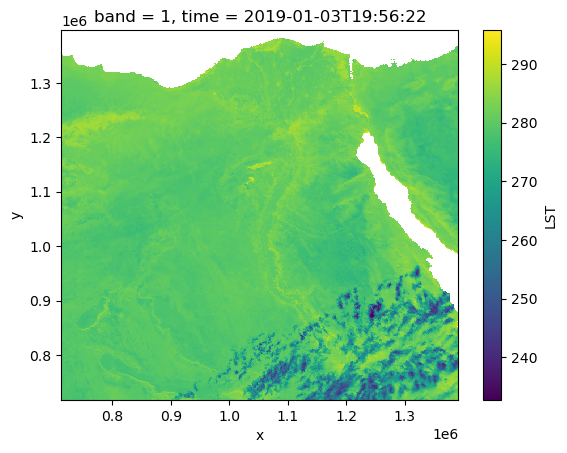

In [15]:
lst['LST'].isel(time=0).plot()

The following shows a video of the data. If you are interested in how I made this, I used the `nd` package:
```python
lst['LST'].nd.to_video('data/lst.gif', fps=6, fontcolor=(255, 255, 255), width=300, timestamp='lower left')
```

<img src="data/lst.gif" align="left" width=300>

You can see that the individual images of this time series are not perfectly coregistered,
but we don't need to worry about that for now as we assume noisy data anyway.

### Select a number of points around the Cairo area

We will now generate ten points randomly scattered near the general Cairo area (approx. pixel `[450, 200]`).

For the purpose of this exercise we will treat these pixels as measurements of the same underlying state – i.e., we ignore the possibility of any legitimate differences on the ground between these points.

In [16]:
N = 10
np.random.seed(0)
select = np.random.multivariate_normal([450, 200], 500*np.eye(2), N).astype(int)

Now that we have generated a list of random coordinates, let's visualise these points on an image of the data set:

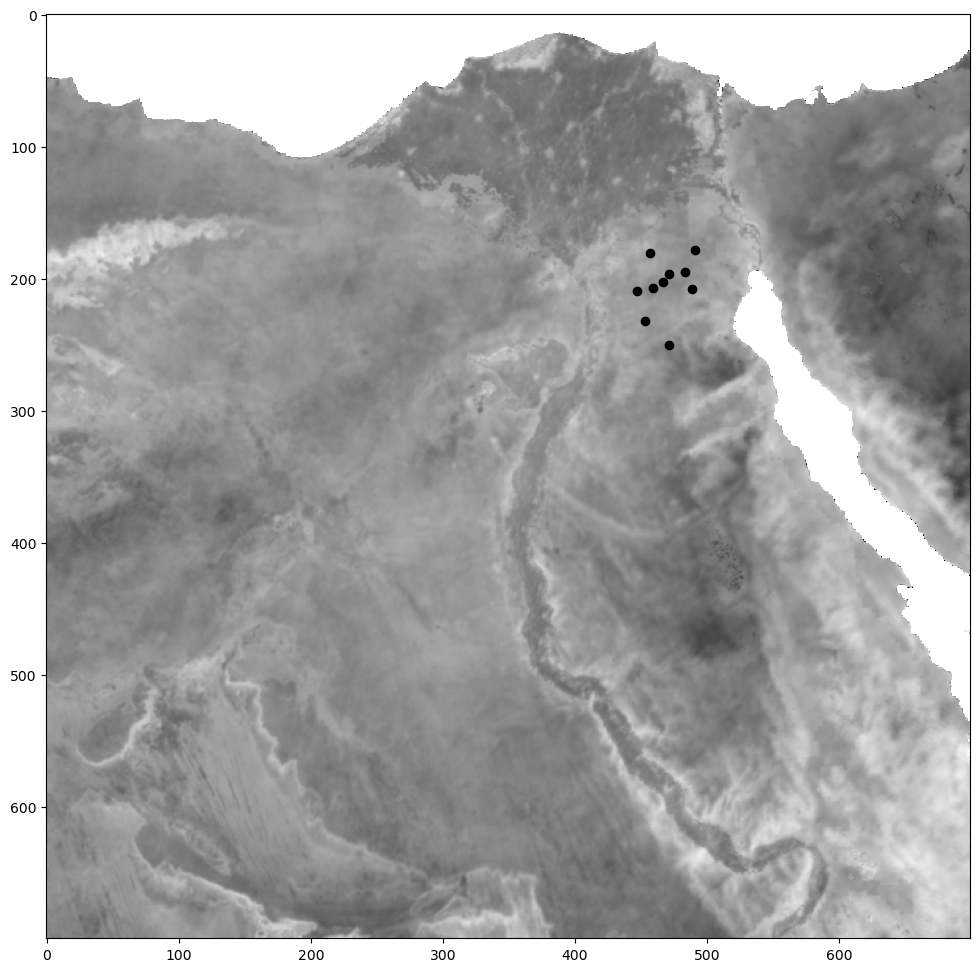

In [17]:
# PLOT
plt.figure(figsize=(12, 12))
im = lst['LST'].mean('time')
plt.imshow(im, cmap='gray', vmin=280, vmax=300)
plt.scatter(select[:, 0], select[:, 1], color='k')

As a next step, we need to extract the time series data at those points:

In [18]:
xmask = xr.DataArray(select[:, 0], dims='z')
ymask = xr.DataArray(select[:, 1], dims='z')
points = lst.isel(x=xmask, y=ymask)

In [21]:
points

<xarray.Dataset>
Dimensions:          (time: 50, z: 10)
Coordinates:
    band             int64 1
    lat              (z) float64 ...
    lon              (z) float64 ...
  * time             (time) datetime64[ns] 2019-01-03T19:56:22 ... 2019-12-30...
    x                (z) float64 1.187e+06 1.17e+06 ... 1.181e+06 1.156e+06
    y                (z) float64 1.195e+06 1.154e+06 ... 1.207e+06 1.222e+06
Dimensions without coordinates: z
Data variables:
    LST              (time, z) float32 282.8 278.6 281.1 ... 277.8 280.3 282.3
    LST_uncertainty  (time, z) float32 ...
Attributes: (12/23)
    GeoTransform:              [ 1.61035890e+06 -9.70859869e+02  0.00000000e+...
    bands:                     1
    byte_order:                1
    coordinate_system_string:  PROJCS["Egypt 1907 / Extended Purple Belt",GEO...
    crs:                       EPSG:22994
    data_gain_values:          1.0
    ...                        ...
    pixel_height:              970.8598686523419
    pixel_width:               970.8598686523419
    res:                       [970.85986865 970.85986865]
    samples:                   1855
    scales:                    1.0
    transform:                 [ 9.69411915e+02  0.00000000e+00  2.28420546e+...

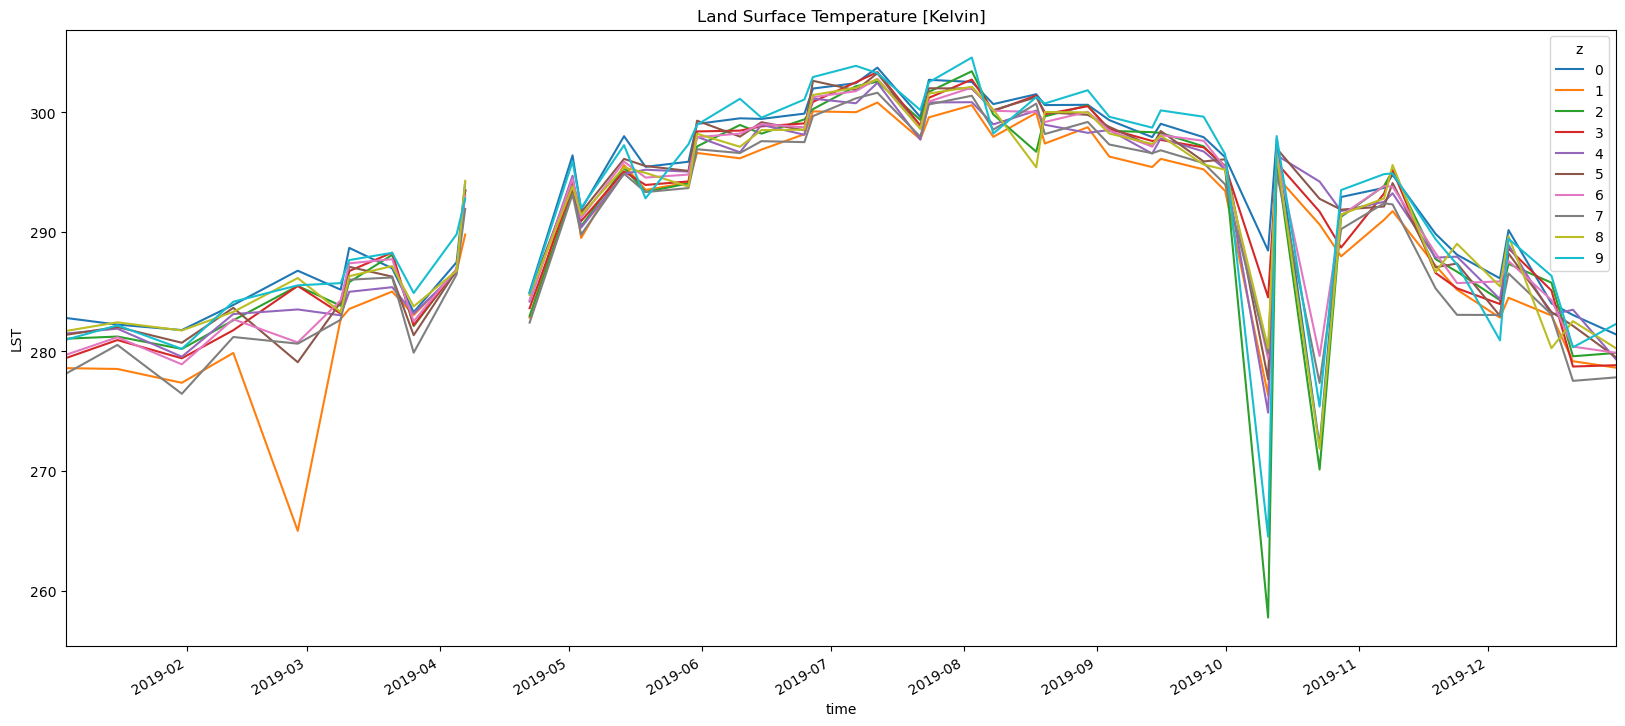

In [19]:
plt.figure(figsize=(20, 8))
points['LST'].plot.line(hue='z')
plt.title('Land Surface Temperature [Kelvin]')
plt.autoscale(enable=True, axis='x', tight=True);

We can already note a few interesting facts about the data:

- There are some missing data at time step 12
- There are a number of outliers with values far below what we would expect (due to clouds)
- The data show a clear seasonal trend
- Overall, the data seem fairly well-behaved.

## Apply Kalman filter

We will now apply a Kalman filter to these real data.

The code we created above requires a few adaptations:

1. We need to deal with the missing data.
2. The number of output states $M$ is different from the number of observations $N$

Whereas for the synthetic data we generated a random model, we now need to think about how to set our parameters to reflect the observations and underlying state we want to model.

In [26]:
y = points['LST'].values.T

This is a very simple example for a number of reasons:

1. The number of output states is $M=1$ (since we naïvely assume that all of the points should in fact have the same underlying state).
2. The data are in fact observations of the underlying state, so our model is a simple one-to-one correspondence and we attribute all difference between the individual observations to noise.

In [83]:
M = 1
A = np.eye(M)
H = np.ones((N, M)) / M
Q = np.eye(M) #*10
R = np.eye(N) * 30 

In [84]:
Nk = y.shape[1]

m = np.zeros((M, Nk))
P = np.zeros((M, M, Nk))

# Set prior mean and covariance explicitly:
m[:, 0] = np.nanmean(y[:, 0])
P[:, :, 0] = Q

mp = m.copy()
Pp = P.copy()

We modify our code from above slightly to account for the missing data,
in which case we just skip the update step:

In [85]:
for k in range(1, Nk):
    # 1. Prediction step
    mp[:, k] = A.dot(m[:, k-1])
    Pp[:, :, k] = A.dot(P[:, :, k-1]).dot(A.T) + Q
    
    # If there is any missing data, skip update step
    if np.isnan(y[:, k]).any():
        m[:, k] = mp[:, k]
        P[:, :, k] = Pp[:, :, k]
        continue
        
    # 2. Update step
    v = y[:, k] - H.dot(mp[:, k])
    S = H.dot(Pp[:, :, k]).dot(H.T) + R
    K = Pp[:, :, k].dot(H.T).dot(np.linalg.inv(S))
    m[:, k] = mp[:, k] + K.dot(v)
    P[:, :, k] = Pp[:, :, k] - K.dot(S).dot(K.T)


### Visualise the result

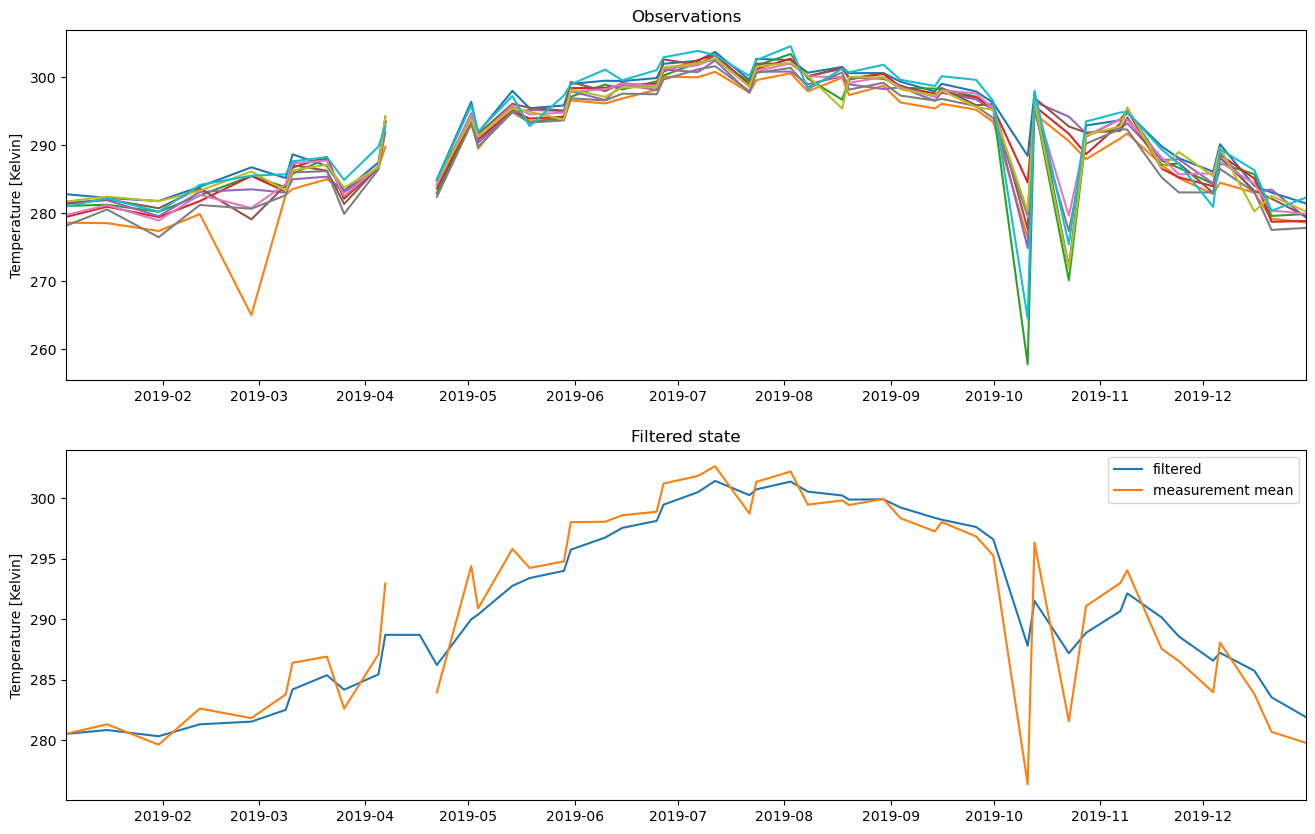

In [86]:
time = points['time'].values

fig, ax = plt.subplots(2, 1, figsize=(16, 10))
ax[0].plot(time, y.T)
ax[0].set_title('Observations')
ax[1].plot(time, m.T, label='filtered')
ax[1].plot(time, y.mean(0), label='measurement mean')
ax[1].legend()
ax[1].set_title('Filtered state')
for a in ax:
    a.set_ylabel('Temperature [Kelvin]')
    a.autoscale(enable=True, axis='x', tight=True)

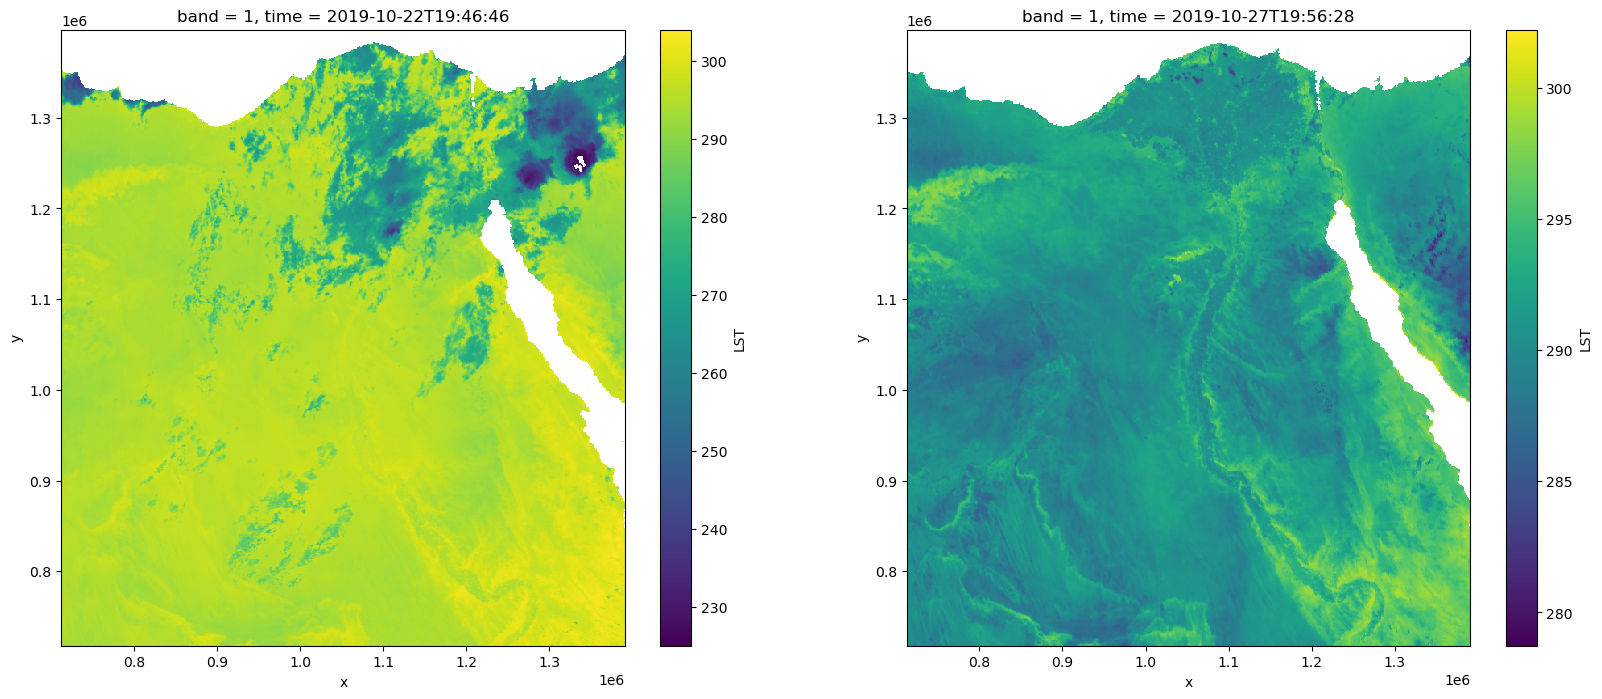

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

lst['LST'].isel(time=39).plot(ax=ax[0])
lst['LST'].isel(time=40).plot(ax=ax[1])

In addition, we can also plot the predictive mean and covariance $m^-_k$ and $P^-_k$ (our variables `mp` and `Pp`, respectively) along with the original observations.

As you can see, the predictive mean is essentially a smoothed mean of the original observations. We can also easily spot outliers as they lie outside the confidence band spanned by the predictive covariance.

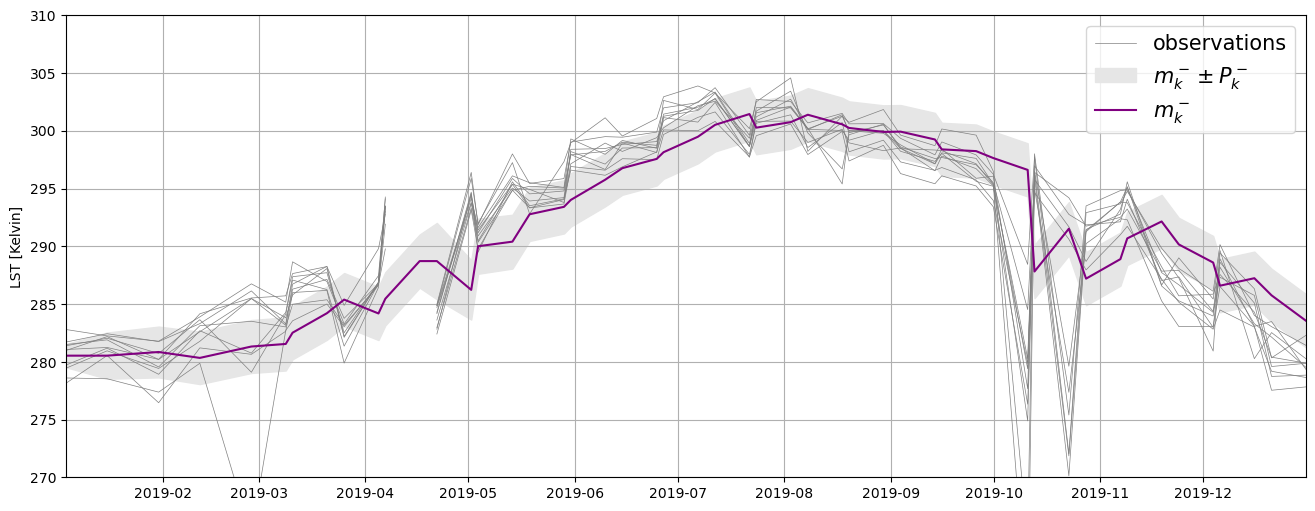

In [94]:
plt.figure(figsize=(16, 6))

# Plot the original observations
h = plt.plot(time, y.T, color='0.5', linewidth=0.5)
# Add legend entry for one of the lines
h[0].set_label('observations')

# Add gray band to indicate covariance
error = (Pp.diagonal(axis1=0, axis2=1)).flatten() # standard deviation?
plt.fill_between(time, mp.flatten() - error, mp.flatten() + error, color='0.9', label='$m^-_k \pm P^-_k$')

# Plot predictive means
plt.plot(time, mp.T, color='purple', label='$m^-_k$')

plt.ylim([270, 310])
plt.ylabel('LST [Kelvin]')
plt.legend(fontsize=15)
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()

Short time-series can cause over fitting of kalman filter

High P, likely to be overfit.



## Exercise 2: Explore the effect of changing the model parameters

What is the model parameters (especially $\mathbf{Q}$ and $\mathbf{R}$) in the example above? Investigate how the result changes if we modify these parameters.